In [ ]:
!pip install PARCtorch-0.4.0-py3-none-any.whl
!pip install wandb==0.16.1
!pip install torch-harmonics==0.6.4
!pip install neuraloperator==0.3.0

In [1]:
import neuralop


if neuralop.__version__ != "0.3.0":
    print("This work uses neuralop 0.3.0. If you are reproducing this work please use the same version.")

In [2]:
# PARCv2
from PARCtorch.PARCv2 import PARCv2
from PARCtorch.utilities.unet import UNet
from PARCtorch.differentiator.finitedifference import FiniteDifference
from PARCtorch.integrator.integrator import Integrator
from PARCtorch.integrator.rk4 import RK4
from PARCtorch.differentiator.advection import AdvectionUpwind
from PARCtorch.differentiator.differentiator import ADRDifferentiator
# FNO
from neuralop.models.fno import TFNO2d
# Neural ODE
from node import ResNet2D
# PyTorch
import torch
import torch.nn as nn
# Others
import numpy as np
import h5py
import json
import os
import random

In [3]:
torch.set_grad_enabled(False)

In [4]:
env_dict = {"data_dir": "/standard/sds_baek_energetic/data/physics/shear_bands/skip_5"}
data_dir = env_dict["data_dir"]

### Data Loading

In [5]:
with h5py.File(data_dir + "/RDX_train_val_720_2880_20_test_100_normalization.hdf5") as f:
    min_val = torch.tensor(f["channel_min"][:], dtype=torch.float32)
    max_val = torch.tensor(f["channel_max"][:], dtype=torch.float32)
test_idx = [1800]

### PARCv2 Inference

In [6]:
n_fe_features = 64
unet_em = UNet([64, 64*2, 64*4, 64*8, 64*16], 5, n_fe_features, up_block_use_concat=[False, True, False, True], skip_connection_indices=[2, 0])
cdiff = FiniteDifference(filter_1d=np.array([-0.5, 0.0, 0.5]), padding_mode="reflect").cuda()
rk4_int = RK4().cuda()
diff_em = ADRDifferentiator(3,                 # 3 state variables: T, p, mu. We always assume 2 velocity being the last 2 channels
                            n_fe_features,     # Number of features returned by the feature extraction network: 64
                            [0, 1, 2, 3, 4],   # Channel indices to calculate advection: all channels
                            [],                # No diffusion
                            unet_em,           # Feature extraction network: unet_em
                            "reflect",         # Padding mode: reflect for zero gradient
                            cdiff,             # Finite difference method: central difference
                            False              # Disable random gaussian noise
                           )
# Upwind instead of linear scheme
ldiff = FiniteDifference(padding_mode="reflect", right_bottom=False).cuda()
rdiff = FiniteDifference(padding_mode="reflect", right_bottom=True).cuda()
for i in range(len(diff_em.list_adv)):
    if diff_em.list_adv[i] is not None:
        diff_em.list_adv[i] = AdvectionUpwind(ldiff, rdiff)
# Data driven integrator
ddi_list = [None] * 5
em_int = Integrator(False,                          # Clip input data between 0 and 1
                    [],                             # No Poisson
                    rk4_int,                        # RK4 integration
                    ddi_list,                       # Data driven integrators: None
                    "reflect",                      # Padding mode: reflect for zero gradient
                    cdiff                           # Finite difference method: central difference
                   )
parc_model = PARCv2(diff_em, em_int, None).cuda()
parc_model.eval();
parc_model.load_state_dict(torch.load("checkpoints/parcv2/best_val_loss.pt", weights_only=False)["model_state_dict"])

<All keys matched successfully>

In [7]:
pred_dir = "predictions/test_set_parcv2"
os.makedirs(pred_dir, exist_ok=True)
for run_id in test_idx:
    h5py_path = data_dir + "/RDX_Up%i_interp.hdf5" % run_id
    if not os.path.isfile(h5py_path):
        print(h5py_path, " does not exist")
        continue
    with h5py.File(h5py_path) as f:
        future_steps = f["timesteps"].shape[0] - 1
        ic = torch.tensor(f["snapshots"][0:1, ...], dtype=torch.float32).permute(0, 3, 1, 2)
    ic = (ic - min_val[None, :, None, None]) / (max_val[None, :, None, None] - min_val[None, :, None, None])
    t0 = torch.tensor(0.0, dtype=torch.float32)
    t1 = torch.tensor(range(1, future_steps+1), dtype=torch.float32) * 0.1
    pred = parc_model(ic.cuda(), t0.cuda(), t1.cuda()).detach().cpu()[:, 0, :, :, :]
    pred_denorm = pred * (max_val[None, :, None, None] - min_val[None, :, None, None]) + min_val[None, :, None, None]
    np.save(pred_dir + "/RDX_Up%i_interp.npy" % run_id, pred_denorm.permute(0, 2, 3, 1).numpy())

### FNO Inference

In [8]:
class RecursiveFNO(nn.Module):
    '''
    Interface such that FNO can be called recursively and has the same forward() signature as PARCv2
    '''
    def __init__(self, fno_model):
        super().__init__()
        self.fno_model = fno_model
    
    def forward(self, x, t0, t1):
        output = []
        for i in range(t1.shape[0]):
            x = self.fno_model(x)
            output.append(x.unsqueeze(0))  # b, c, y, x
        output = torch.cat(output, dim=0)
        return output


fno = TFNO2d(n_modes_height=24, n_modes_width=24, hidden_channels=78, 
             in_channels=5, out_channels=5,
             lifting_channels=78, projection_channels=78).cuda()
fno_model = RecursiveFNO(fno).cuda()
fno_model.eval()
fno_model.load_state_dict(torch.load("checkpoints/fno/best_val_loss.pt", weights_only=False)["model_state_dict"])

<All keys matched successfully>

In [9]:
pred_dir = "predictions/test_set_fno"
os.makedirs(pred_dir, exist_ok=True)
for run_id in test_idx:
    h5py_path = data_dir + "/RDX_Up%i_interp.hdf5" % run_id
    if not os.path.isfile(h5py_path):
        print(h5py_path, " does not exist")
        continue
    with h5py.File(h5py_path) as f:
        future_steps = f["timesteps"].shape[0] - 1
        ic = torch.tensor(f["snapshots"][0:1, ...], dtype=torch.float32).permute(0, 3, 1, 2)
    ic = (ic - min_val[None, :, None, None]) / (max_val[None, :, None, None] - min_val[None, :, None, None])
    t0 = torch.tensor(0.0, dtype=torch.float32)
    t1 = torch.tensor(range(1, future_steps+1), dtype=torch.float32) * 0.1
    pred = fno_model(ic.cuda(), t0.cuda(), t1.cuda()).detach().cpu()[:, 0, :, :, :]
    pred_denorm = pred * (max_val[None, :, None, None] - min_val[None, :, None, None]) + min_val[None, :, None, None]
    np.save(pred_dir + "/RDX_Up%i_interp.npy" % run_id, pred_denorm.permute(0, 2, 3, 1).numpy())

### Neural ODE Inference

In [10]:
class CKParc(PARCv2):
    def __init__(self, differentiator, integrator, loss, **kwargs):
        super().__init__(differentiator, integrator, loss)

    def forward(self, ic, t0, t1):  
        diff_ck = lambda t, x: self.differentiator(x)  
        return self.integrator(diff_ck, ic, t0, t1)


diff_em = ResNet2D(in_channels=5, base_channels=[460, 460, 460, 460, 460], out_channels=5, 
                   padding_mode='zeros').cuda()
rk4_int = RK4().cuda()
ddi_list = [None] * 5
int_em = Integrator(False,                          # Clip input data between 0 and 1
                    [],                             # No Poisson
                    rk4_int,                        # RK4 integration
                    ddi_list,                       # Data driven integrators: None
                    "reflect",                      # Padding mode: reflect for zero gradient
                    None                           # Finite difference method: central difference
                   )
model = CKParc(diff_em, int_em, None).cuda()
model.eval();
model.load_state_dict(torch.load("checkpoints/node/best_val_loss.pt", weights_only=False)["model_state_dict"])

<All keys matched successfully>

In [11]:
pred_dir = "predictions/test_set_node"
os.makedirs(pred_dir, exist_ok=True)
for run_id in test_idx:
    h5py_path = data_dir + "/RDX_Up%i_interp.hdf5" % run_id
    if not os.path.isfile(h5py_path):
        print(h5py_path, " does not exist")
        continue
    with h5py.File(h5py_path) as f:
        future_steps = f["timesteps"].shape[0] - 1
        ic = torch.tensor(f["snapshots"][0:1, ...], dtype=torch.float32).permute(0, 3, 1, 2)
    ic = (ic - min_val[None, :, None, None]) / (max_val[None, :, None, None] - min_val[None, :, None, None])
    t0 = torch.tensor(0.0, dtype=torch.float32)
    t1 = torch.tensor(range(1, future_steps+1), dtype=torch.float32) * 0.1
    pred = model(ic.cuda(), t0.cuda(), t1.cuda()).detach().cpu()[:, 0, :, :, :]
    pred_denorm = pred * (max_val[None, :, None, None] - min_val[None, :, None, None]) + min_val[None, :, None, None]
    np.save(pred_dir + "/RDX_Up%i_interp.npy" % run_id, pred_denorm.permute(0, 2, 3, 1).numpy())

### Visualization

In [12]:
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt


gt_path = data_dir + "/RDX_Up%i_interp.hdf5"
parcv2_pred_path = "predictions/test_set_parcv2/RDX_Up%i_interp.npy"
fno_pred_path = "predictions/test_set_fno/RDX_Up%i_interp.npy"
node_pred_path = "predictions/test_set_node/RDX_Up%i_interp.npy"

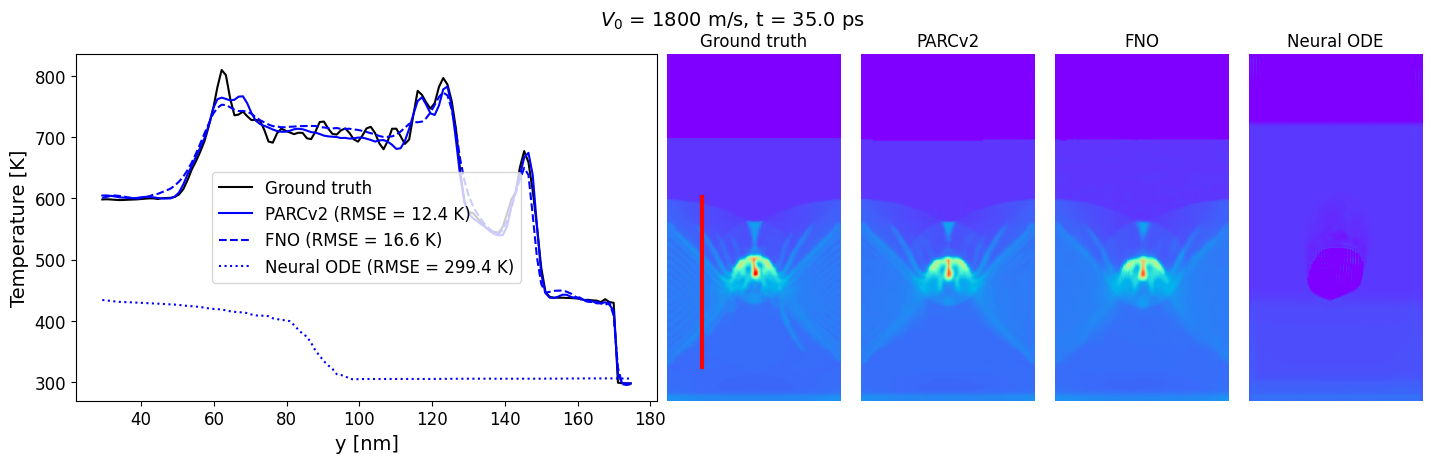

In [13]:
run_id_list = [1800]
idx_pct = [0.65]
for iidx, run_id in enumerate(run_id_list):
    h5py_path = gt_path % run_id
    with h5py.File(h5py_path) as f:
        sim_700 = f["snapshots"][1:, ...]
        vmin = f["channel_min"][:]
        vmax = f["channel_max"][:]
    idx = int(sim_700.shape[0] * idx_pct[iidx])
    t = (idx + 1) * 2.5
    
    pred_ib = np.load(parcv2_pred_path % run_id)
    pred_vgg = np.load(fno_pred_path % run_id)
    pred_node = np.load(node_pred_path % run_id)

    to_plot = [sim_700, pred_ib, pred_vgg, pred_node]
    to_plot_label = ["Ground truth", "PARCv2", "FNO", "Neural ODE"]
    to_plot_fmt = ["k-", "b-", "b--", "b:"]
    
    wr = [3]
    for _ in range(len(to_plot)):
        wr.append(1)
    fig, ax = plt.subplots(1, len(to_plot)+1, figsize=(sum(wr)*2.5, 4.5), 
                           gridspec_kw={"hspace": 0, "wspace": 0, "width_ratios": wr})
    # Comparison figure
    xx = np.array(range(25, 150)) * 1.1719
    for i in range(len(to_plot)):
        if i!=0:
            l1_loss = np.sqrt(np.mean((to_plot[i][idx, 25:150, 25, 0] - to_plot[0][idx, 25:150, 25, 0]) ** 2.0))
            ax[0].plot(xx, to_plot[i][idx, 25:150, 25, 0], to_plot_fmt[i], label=to_plot_label[i] + r" (RMSE = %.1f K)" % l1_loss)
        else:
            ax[0].plot(xx, to_plot[i][idx, 25:150, 25, 0], to_plot_fmt[i], label=to_plot_label[i])
    # Snapshot
    vmin, vmax = np.min(to_plot[0][idx, :, :, 0]), np.max(to_plot[0][idx, :, :, 0])
    for i, each in enumerate(to_plot):
        ax[i+1].imshow(each[idx, :, :, 0], cmap="rainbow", origin="lower", vmin=vmin, vmax=vmax)
        ax[i+1].axis("off")
        ax[i+1].set_title(to_plot_label[i], fontsize=12)
    ax[1].plot([24, 24], [24, 151], "r-")
    ax[1].plot([24, 26], [24, 24], "r-")
    ax[1].plot([26, 26], [24, 151], "r-")
    ax[1].plot([24, 26], [151, 151], "r-")
    ax[0].legend(fontsize=12)
    ax[0].set_xlabel("y [nm]", fontsize=14)
    ax[0].set_ylabel("Temperature [K]", fontsize=14)
    ax[0].tick_params("both", labelsize=12)
    fig.suptitle(r"$V_0$ = %i m/s, t = %.1f ps" % (run_id, t), fontsize=14)
    plt.show()

A small difference (<5%) in RMSE values are expected on different hardware, due to various operations (e.g. convolution) in pytorch use non-determinstic algorithms.